In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.75)

In [2]:
obj_fn = lambda x: np.maximum(-0.125 * x ** 2 + 16 * np.sin(x), 0)

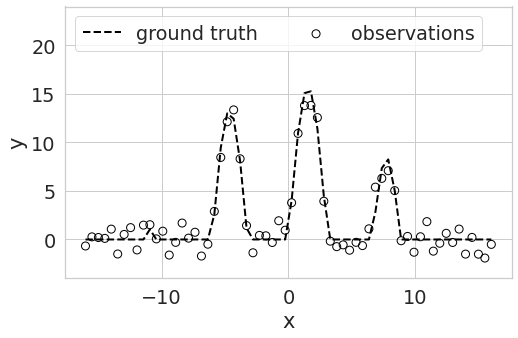

In [3]:
fig = plt.figure(figsize=(8, 5))

noise_scale = 1.
x_bounds = torch.tensor((-16., 16.)).view(-1, 1)

x = np.linspace(*x_bounds, 64)
f = obj_fn(x)
y = f + noise_scale * np.random.randn(*f.shape)

plt.scatter(x, y, edgecolors='black', facecolors='none', label='observations', s=64, zorder=3)
plt.plot(x, f, color='black', linestyle='--', label='ground truth', linewidth=2, zorder=2)

plt.ylabel('y')
plt.xlabel('x')
plt.ylim((-4, 24))
plt.legend(loc='upper left', ncol=2)

In [4]:
import botorch
from botorch.fit import fit_gpytorch_model
from botorch.acquisition.analytic import UpperConfidenceBound, ExpectedImprovement
from botorch.optim.optimize import optimize_acqf

from gpytorch.mlls import ExactMarginalLogLikelihood

In [5]:
def draw_plot(ax):
    # plot p(f | x, D)
    ax.plot(all_inputs, f_hat_mean, color='blue', linewidth=2, zorder=4, label='p(f | x, D)')
    ax.fill_between(all_inputs.view(-1), f_hat_mean - 2 * f_hat_std, f_hat_mean + 2 * f_hat_std,
                    color='blue', alpha=0.25)

    # plot a(x)
    ax.plot(all_inputs, acq_vals, color='green', zorder=5, linewidth=2, label='a(x)')
    ax.scatter(input_query, target_query, marker='x', color='red', label='x*', zorder=5,
               s=32, linewidth=2)

    # plot observed
    ax.scatter(train_inputs, train_targets, edgecolors='black', facecolors='black',
               label='D', s=32, zorder=3)
    # plot unobserved
#     plt.scatter(all_inputs, all_targets,
#                 edgecolors='black', facecolors='none', label='unobserved', s=32, zorder=3)

    # plot true function
    ax.plot(all_inputs, (f - y_loc) / y_scale, color='black', linestyle='--', label='f')

    # plot training cutoff
    # plt.vlines((-8 - x_loc) / x_scale, *plt.ylim(), color='red', linestyle='--')

    ax.set_ylim((-4, 24))

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    return ax

In [6]:
from bo_protein.utils import DataSplit, update_splits

cutoff = np.max(np.where(x < -8))

train_x = x[:cutoff]
x_loc = train_x.mean(0)
x_scale = train_x.std(0)

train_y = y[:cutoff]
y_loc = train_y.mean(0)
y_scale = train_y.std(0)

all_inputs = torch.tensor(
    (x - x_loc) / x_scale
).view(-1, 1)
all_targets = torch.tensor(
    (y - y_loc) / y_scale
).view(-1, 1)

new_split = DataSplit(all_inputs[:cutoff].numpy(), all_targets[:cutoff].numpy())
train_split, val_split, test_split = update_splits(
    train_split=DataSplit(),
    val_split=DataSplit(),
    test_split=DataSplit(),
    new_split=new_split,
    holdout_ratio=0.2
)

input_bounds = (x_bounds - x_loc) / x_scale

12 train, 1 val, 2 test
16 train, 3 val, 4 test
22 train, 5 val, 4 test
27 train, 6 val, 6 test


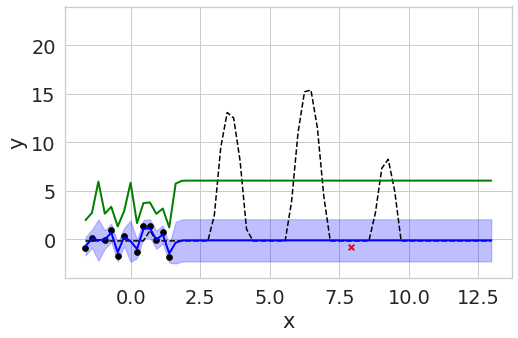

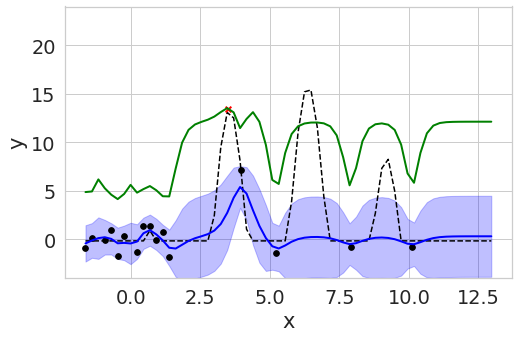

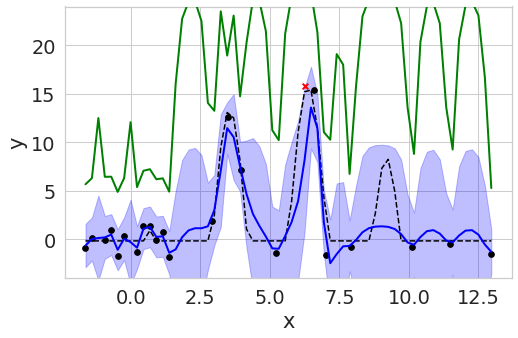

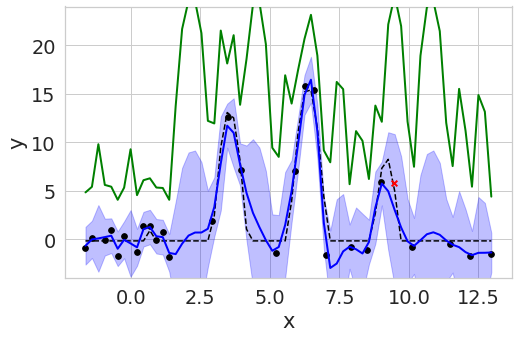

In [7]:
num_rounds = 32
plot_interval = 8

for round_idx in range(num_rounds):
    train_inputs = torch.tensor(train_split[0])
    train_targets = torch.tensor(train_split[1])
    
    matern_gp = botorch.models.SingleTaskGP(train_inputs, train_targets)
    mll = ExactMarginalLogLikelihood(matern_gp.likelihood, matern_gp)
    fit_gpytorch_model(mll)
    acq_fn = UpperConfidenceBound(matern_gp, beta=32.)
#     acq_fn = ExpectedImprovement(matern_gp, best_f=train_targets.max())
    
    matern_gp.eval()
    with torch.no_grad():
        f_hat_dist = matern_gp(all_inputs)
        y_hat_dist = matern_gp.likelihood(f_hat_dist)
        f_hat_mean = f_hat_dist.mean
        f_hat_std = f_hat_dist.variance.sqrt()
        y_hat_mean = f_hat_mean
        y_hat_std = y_hat_dist.variance.sqrt()
        acq_vals = acq_fn(all_inputs[:, None])
        
    input_query = optimize_acqf(acq_fn, input_bounds, 1, num_restarts=4, raw_samples=16)[0]
    x_query = input_query * x_scale + x_loc
    f_query = obj_fn(x_query)
    y_query = f_query + noise_scale * np.random.randn(*f_query.shape)
    target_query = (y_query - y_loc) / y_scale
    
    if round_idx % plot_interval == 0:
        print(f'{train_split[0].shape[0]} train, {val_split[0].shape[0]} val, {test_split[0].shape[0]} test')
        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(1, 1, 1)
        draw_plot(ax)
    #     plt.close()
    
    new_split = DataSplit(input_query.reshape(-1, 1), target_query.reshape(-1, 1))
    train_split, val_split, test_split = update_splits(
        train_split, val_split, test_split, new_split, holdout_ratio=0.2
    )


In [ ]:
def conformal_gp_regression(gp, inputs, target_grid, score_quantile):
    """
    Args:
        gp (gpytorch.models.GP)
        inputs (torch.Tensor): (num_inputs, input_dim)
        target_grid (torch.Tensor): (grid_size, target_dim)
        score_quantile: (target_dim)
    Returns:
        conf_pred_mask (torch.Tensor): (num_inputs, grid_size)
    """
    expanded_inputs = inputs.expand(target_grid.shape[0], -1, -1)
    expanded_inputs = expanded_inputs.transpose(1, 0)  # (num_inputs, grid_size, input_dim)
    
    expanded_targets = target_grid.expand(
        inputs.shape[0], -1, -1
    )  # (num_inputs, grid_size, target_dim)    
    
    updated_gps = gp.condition_on_observations(expanded_inputs, expanded_targets)
    
    train_targets = updated_gps.train_targets
    train_covar = updated_gps.train_full_covar
    noise = updated_gps.likelihood.noise
    
    eig_vals, eig_vecs = train_covar.symeig(eigenvectors=True)
    
    lhs = eig_vecs @ torch.diag(eig_vals / (eig_vals + noise))
    pred_mean = lhs @ train_targets
    pred_covar = lhs @ eig_vecs.transpose(-1, -2)
    pred_var = pred_covar.diag()
    
    pred_dist = torch.distributions.Normal(pred_mean, pred_var.sqrt())
    scores = pred_dist.log_prob(expanded_targets)
    conf_pred_mask = (scores > score_quantile).prod(-1)
    
    return conf_pred_mask

In [8]:
from bo_protein.models.gp_models import SingleTaskExactGP
from gpytorch.kernels import MaternKernel
from gpytorch.priors import NormalPrior

from torch import nn

input_dim = train_inputs.shape[-1]
hidden_dim = 64
feature_dim = input_dim
target_dim = train_targets.shape[-1]

mlp_encoder = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, feature_dim),
)
covar_module = MaternKernel(lengthscale_prior=NormalPrior(0.7, 1e-2))

dkl_gp = SingleTaskExactGP(feature_dim, target_dim, mlp_encoder, covar_module=covar_module)

TypeError: __init__() missing 11 required positional arguments: 'max_shift', 'mask_size', 'gp_lr', 'enc_lr', 'bs', 'num_epochs', 'holdout_ratio', 'early_stopping', 'patience', 'eval_period', and 'tokenizer'